In [1]:
!pip install tensorflow==1.15

In [2]:
!pip install tensorflow-gpu==1.15

  Using cached https://files.pythonhosted.org/packages/4c/dd/68e607b7c58e7977fe23de0cb27e8a288eabc82a121f7733bf0e6ef2a9a6/tensorflow_gpu-1.15.0-cp37-cp37m-win_amd64.whl
  Found existing installation: tensorflow-gpu 2.1.0rc2
    Uninstalling tensorflow-gpu-2.1.0rc2:
      Successfully uninstalled tensorflow-gpu-2.1.0rc2


In [3]:
!pip install pillow

In [4]:
!pip install freetype-py

In [5]:
!pip install pypng

In [6]:
!pip install tqdm

In [5]:
data_dir = '/data'
import helper

helper.download_extract('celeba', data_dir)

Found celeba Data


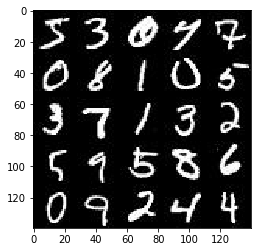

In [7]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

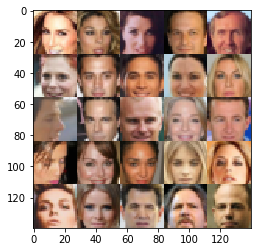

In [8]:
show_n_images = 25
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [9]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.15.0


C:\Users\DELL\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    l_r = tf.placeholder(tf.float32, name='l_r')
    return input_real, input_z, l_r

tests.test_model_inputs(model_inputs)


Tests Passed


In [11]:
def discriminator(images, reuse=False):


    alpha = 0.12 # between 0.6 and 0.18
    keep_prob = 0.5

    with tf.variable_scope('discriminator', reuse=reuse):        

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        relu1 = tf.maximum(alpha * x1, x1)        
 
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        d2 = tf.nn.dropout(relu2, keep_prob=keep_prob)

        
        x3 = tf.layers.conv2d(d2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        d3 = tf.nn.dropout(relu3, keep_prob=keep_prob)



        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

tests.test_discriminator(discriminator, tf)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\DELL\problem_unittests.py", line 38, in _check_input
    '{} has bad name.  Found name {}'.format(display_name, tensor.name)  File "C:\Users\DELL\problem_unittests.py", line 27, in _assert_tensor_shape
    '{} has wrong shape.  Found {}'.format(display_name, tensor_shape)  File "C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow_core\python\ops\check_ops.py", line 1155, in assert_rank
    return assert_op  File "C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow_core\python\ops\check_ops.py", line 1060, in _assert_rank_condition
    return control_flow_ops.Assert(condition, data, summarize=summarize)  File "C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow_core\python\util\tf_should

In [12]:
def generator(z, out_channel_dim, is_train=True):

    alpha = 0.12 
    keep_prob = 0.5
    

    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*1024)
        
             
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        

        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)

        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)  
      
        

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')

        
        out = tf.tanh(logits)    
    
    return out

tests.test_generator(generator, tf)

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Tests Passed


In [13]:
def model_loss(input_real, input_z, out_channel_dim):

    smooth = 0.2 

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake) * (1 - smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Tests Passed


In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
   
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)    
    
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)


Tests Passed


In [15]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):

    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [16]:
def plot_losses(d_loss_vec, g_loss_vec):
    print(d_loss_vec, g_loss_vec)
    Discriminator_loss, = pyplot.plot(d_loss_vec, color='b', label='Discriminator loss')
    Genereator_loss, = pyplot.plot(g_loss_vec, color='r', label='Generator loss')
    pyplot.legend(handles=[ Discriminator_loss, Genereator_loss])    
    

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
  
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, l_r = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_r, beta1)
    d_loss_vec = []
    g_loss_vec = []
    
    try:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch_i in range(epoch_count):
                for batch_images in get_batches(batch_size):
                    
                    batch_images *= 2 
                    steps += 1

                    
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))      

                   
                    _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r: learning_rate})

                    
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_r: learning_rate})
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_r: learning_rate})

                   
                    if steps % 10 == 0:
                        train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                        train_loss_g = g_loss.eval({input_z: batch_z})   
                        d_loss_vec.append(train_loss_d)
                        g_loss_vec.append(train_loss_g)
                    
                   
                    if steps % 100 == 0:                        
                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))

                        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        plot_losses(d_loss_vec, g_loss_vec)
    
    except KeyboardInterrupt:
        plot_losses(d_loss_vec, g_loss_vec)
        raise

Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 1.1624


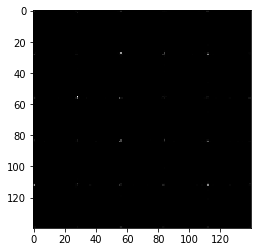

Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 0.9677


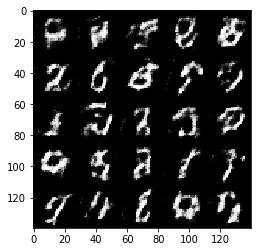

Epoch 1/2... Discriminator Loss: 1.5048... Generator Loss: 0.7035


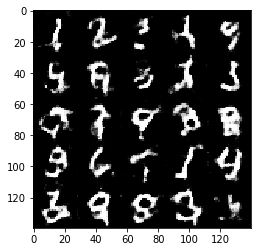

[2.3674922, 1.4233949, 1.354505, 1.5974425, 1.7411422, 1.698001, 1.8026887, 1.4821448, 1.5248518, 1.3447578, 1.6655143, 1.3068986, 1.6082455, 1.8707266, 1.6603773, 1.5925792, 1.2851906, 1.5867487, 1.3268287, 1.4406123, 1.4552283, 1.2668066, 1.3564911, 1.4402311, 1.3622139, 1.2341399, 1.4769664, 1.4554231, 1.4591979, 1.5048223, 1.3441415, 1.4693725, 1.5060894, 1.2838184, 1.4103467, 1.3996811, 1.4617975] [0.29498994, 1.2446581, 1.3306748, 1.1609693, 1.2238244, 0.55735487, 0.4944764, 0.9871779, 0.8980997, 1.1623688, 0.8422079, 0.83791554, 1.1899657, 0.57955647, 1.4260956, 0.74877536, 0.9554169, 0.75006795, 1.0726793, 0.9676938, 1.0707519, 1.5968196, 1.1738427, 0.6732168, 1.0880291, 1.2871546, 1.1443224, 0.9905118, 0.8464803, 0.70351183, 0.9605808, 0.9940247, 1.1892159, 0.98838377, 1.2004776, 0.8791448, 0.7135132]


KeyboardInterrupt: 

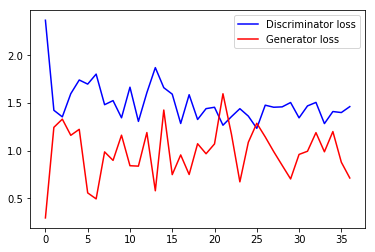

In [17]:

batch_size = 32 
z_dim = 128 
learning_rate = 0.0003 
beta1 = 0.4 


epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 2.6688


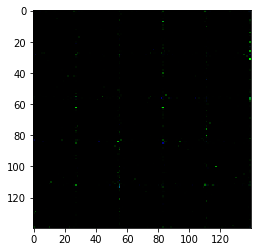

Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.6609


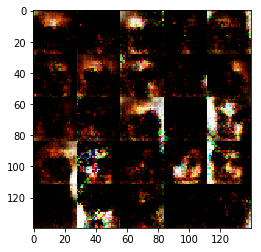

Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 1.1517


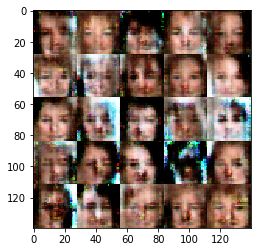

Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.0079


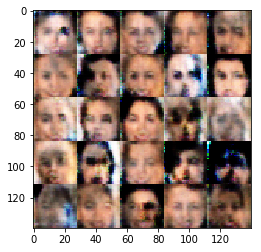

Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.2250


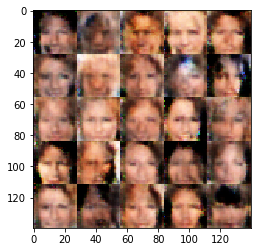

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8313


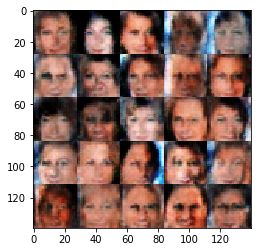

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.9563


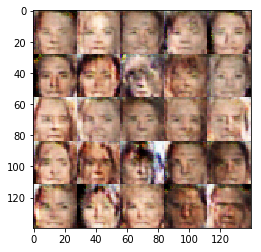

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.9261


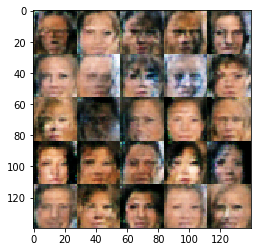

Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8775


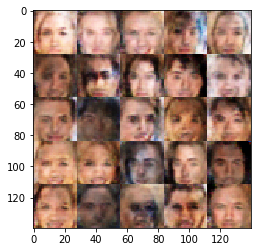

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.9917


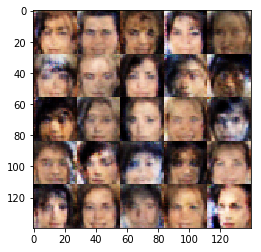

Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.8431


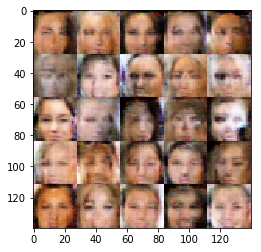

Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.8438


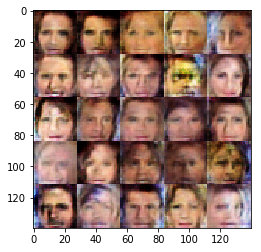

Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8836


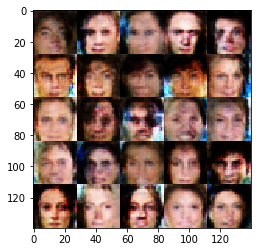

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.8613


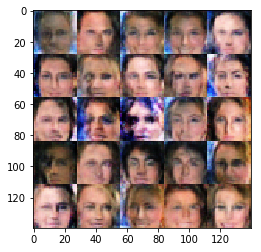

Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 1.0540


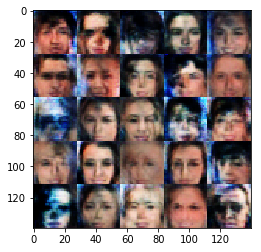

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7646


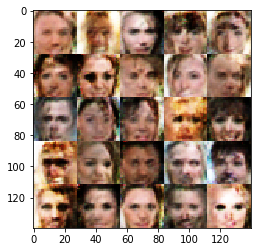

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8705


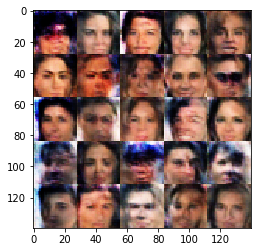

Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.8705


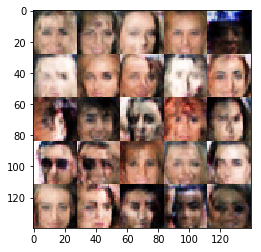

Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.8462


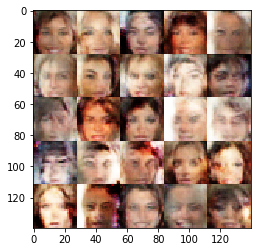

[0.7213638, 1.1946716, 1.5499227, 1.2825387, 1.1353014, 0.89209735, 0.7436712, 0.79055256, 1.0244905, 1.1161367, 1.1178007, 1.0867416, 1.1285882, 1.1747546, 1.3794713, 1.2902043, 1.9432476, 1.3923799, 1.2145975, 1.4765615, 1.2984262, 1.4841962, 1.420476, 1.3777183, 1.6558118, 1.3328736, 1.4690948, 1.4411298, 1.767411, 1.3715761, 2.1039405, 1.4786412, 1.7805598, 1.5138526, 1.2054216, 1.4682299, 1.3778147, 1.6860247, 1.591177, 1.166107, 1.4090142, 1.228005, 1.2669271, 1.2564272, 1.460413, 1.3759122, 1.5676494, 1.5515066, 1.4477531, 1.2738721, 1.4370093, 1.2439781, 1.4370587, 1.5577526, 1.4282007, 1.5388424, 1.3337164, 1.3882372, 1.5063406, 1.413501, 1.5344625, 1.2755506, 1.3697194, 1.500752, 1.4528732, 1.4154279, 1.3079579, 1.4827586, 1.255651, 1.372077, 1.4000962, 1.3680372, 1.3427854, 1.373596, 1.4173613, 1.3235898, 1.573405, 1.3998535, 1.4252528, 1.343994, 1.3503294, 1.3733788, 1.4312277, 1.385325, 1.5177652, 1.4599835, 1.3846861, 1.3898563, 1.4092481, 1.3496705, 1.5526512, 1.4610367,

KeyboardInterrupt: 

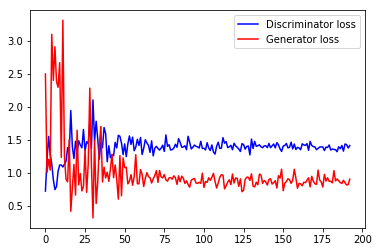

In [18]:
# if batch size is too small use small learning rate as gradients will be more unstable
batch_size = 32 # start experimenting between 16 and 32
z_dim = 128 # 128 - 256
learning_rate = 0.0003 # between 0.0002 and 0.0008
beta1 = 0.4 # between 0.2 and 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)